# 관람자 리뷰 기반 영화 추천
##코드

### 필요한 라이브러리, 마운트 설치

In [1]:
#마운트 (구글 드라이브와 연결)
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver '/content/drive/MyDrive/Colab Notebooks' # (최초 1회)
!pip install chromedriver-autoinstaller
# KoNLPy 라이브러리 설치
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 33.7 MB/s eta 0:00:00
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4,428 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://security.ubuntu.com/ubuntu j

In [2]:
# 모든 임포트와 준비사항을 실행하는 코드
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.select import Select
from urllib.request import urlretrieve
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.keys import Keys
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
from PIL import Image # 이미지를 열고, 조작하며 저장

import urllib.request
import sys, os, time
import bs4
import pandas as pd
import chromedriver_autoinstaller  # setup chrome options
import numpy as np
import matplotlib.pyplot as plt
import numpy as np # 배열 및 행렬 연산


# https://storage.googleapis.com/chrome-for-testing-public/126.0.6478.126/win64/chromedriver-win64.zip 에서 다운받아서
# 본인의 구글 드라이브에 /Colab Notebooks/chromedriver에 넣어놀 것, 만약 안되면
chrome_path = "/content/drive/MyDrive/Colab Notebooks/chromedriver"
sys.path.insert(0,chrome_path)
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off : cloab은 새창을 지원하지않기 때문에 창 없는 모드
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')  # set path to chromedriver as per your configuration
chrome_options.add_argument('lang=ko_KR') # 한국어

o = Okt()

# driver = webdriver.Chrome(options=chrome_options)
# # chromedriver_autoinstaller.install()  # set the target URL
# driver.close()

##  1. 셀레니움을 사용하여 필요한 정보를 크롤링하기
### 기능1) 하나의 영화에서 출연진과 리뷰들을 가져오는 코드


In [3]:
# 영화 메인 페이지에서 배우 이름을 가져옴
def cast_box(driver):
    cast_xpath = '//*[@id="main_pack"]/div[3]/div[2]/div[3]/div/div[1]/a'
    try:
        cast_in = driver.find_element(By.XPATH, cast_xpath)
    except NoSuchElementException:
        cast_xpath = '//*[@id="main_pack"]/div[3]/div[2]/div[4]/div/div[1]/a'
        try:
            cast_in = driver.find_element(By.XPATH, cast_xpath)
        except NoSuchElementException:
            print(f"Could not find element using either XPath: {cast_xpath}")
    time.sleep(1)
    cast_in.send_keys(Keys.ENTER)

In [4]:
# 아래쪽에서 리뷰 카드를 클릭하여 리뷰 페이지로 이동함
def move_review_page(driver):
  driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.PAGE_DOWN)
  time.sleep(1)
  review_button = '//*[@id="main_pack"]/div[3]/div[2]/div[4]/div/div[2]/div/div/ul/li[3]/a'
  try:
      button = driver.find_element(By.XPATH, review_button)
  except NoSuchElementException:
      driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.PAGE_DOWN)
      time.sleep(1)
      review_button = '//*[@id="main_pack"]/div[3]/div[2]/div[5]/div/div[2]/div/div/ul/li[3]/a'
      try:
          button = driver.find_element(By.XPATH, review_button)
      except NoSuchElementException:
          print(f"Could not find element using either XPath: {review_button}")
  time.sleep(1)
  button.send_keys(Keys.ENTER)

In [5]:
## 스크롤할 박스 요소의 XPATH 또는 다른 선택자
def find_scroll_box(driver):
  scroll_box_xpath = '//*[@id="main_pack"]/div[3]/div[2]/div/div/div[4]/div[4]'
  try:
      scroll_box = driver.find_element(By.XPATH, scroll_box_xpath)
  except NoSuchElementException:
      scroll_box_xpath_2 = '//*[@id="main_pack"]/div[3]/div[2]/div/div/div[3]/div[4]'
      try:
          scroll_box = driver.find_element(By.XPATH, scroll_box_xpath_2)
      except NoSuchElementException:
          print(f"Could not find element using either XPath: {scroll_box_xpath} or {scroll_box_xpath_2}")
  return scroll_box

In [6]:
## 박스 내 스크롤을 가장 아래로 내리는 함수
def scroll_box_to_bottom(box, driver):
  last_height = driver.execute_script("return arguments[0].scrollHeight", box)
  while True:
      # Scroll down to bottom of the box
      driver.execute_script("arguments[0].scrollTop = arguments[0].scrollHeight", box)
      # Wait to load page
      time.sleep(2)
      # Calculate new scroll height and compare with last scroll height
      new_height = driver.execute_script("return arguments[0].scrollHeight", box)
      if new_height == last_height:
          break
      last_height = new_height

In [7]:
# 하나의 영화 정보를 검색하여 캐스팅과 리뷰를 반환하는 bs4로 반환하는 함수
# 드라이버 상태는 영화 하나를 클릭하거나 검색하여 메인 페이지를 띄워 놓은 상태여야 한다.
def scan_one_movie(driver):
  driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.PAGE_DOWN)
  cast_box(driver)
  time.sleep(1)
  driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.PAGE_DOWN)
  cast_page = bs4.BeautifulSoup(driver.page_source, 'html.parser') # 배우 리스트를 가져옴

  driver.back()
  time.sleep(2)
  driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.PAGE_DOWN)
  move_review_page(driver)
  time.sleep(1)
  # 페이지 리뷰들 저장
  # 박스 내 스크롤을 가장 아래로 내리기
  scroll_box = find_scroll_box(driver)
  time.sleep(1)
  scroll_box_to_bottom(scroll_box, driver)
  review_page = bs4.BeautifulSoup(driver.page_source, 'html.parser')

  return cast_page, review_page

In [8]:
def find_by_name(movie_name):
  url = 'https://www.naver.com/'
  driver = webdriver.Chrome(options=chrome_options)
  driver.get(url)
  time.sleep(1)
  search_box = '//*[@id="query"]'
  box = driver.find_element(By.XPATH, search_box)
  box.send_keys(f'영화 {movie_name}')
  box.send_keys(Keys.RETURN)
  time.sleep(1)
  movie_name_data_1 = driver.page_source
  movie_name_data_2 = bs4.BeautifulSoup(movie_name_data_1, 'html.parser')
  zero_page, one_page = scan_one_movie(driver)
  driver.close()
  return movie_name, zero_page, one_page

#### 코드 사용

In [9]:
# 사용법
name, casting_html, reviews_html = find_by_name('설계자')

### 기능2) 장르를 선택하여 해당 장르의 모든 영화의 출연진과 리뷰를 가져오는 코드
- 기능 1을 영화 수만큼 반복함


In [ ]:
def find_by_category(category):
  url = 'https://www.naver.com/'
  if len(category) == 0:
    print('영화 장르 : 드라마/판타지/공포/로맨스/스릴러/코미디/액션/SF/애니메이션')
    category = input('(장르만 입력하세요)보고싶은 장르는 ')
  driver = webdriver.Chrome(options=chrome_options)
  driver.get(url)
  search_box = '//*[@id="query"]'
  box = driver.find_element(By.XPATH, search_box)
  box.send_keys(f'{category} 영화')
  box.send_keys(Keys.RETURN)
  time.sleep(1)
  movie_name_data_1 = {}
  movie_name_data_2 = {}
  movie_name_list = [] ## bs4로 변환된 영화 이름
  review_page = {}
  one_page = {} ## bs4로 변환된 리뷰 데이터
  cast_page = {}
  zero_page = {} ## bs4로 변환된 캐스팅 데이터

  movie_xpath = f'//*[@id="main_pack"]/section[1]/div/div[2]/div[2]/div/div[2]/div[2]/div/div/ul/li'
  movie_card_list = driver.find_elements(By.XPATH, movie_xpath)
  i = 0

  # 영화 숫자 만큼 반복함
  # 영화 하나와 달리 {'영화이름': {출연진}} {영화이름: 리뷰들} 딕셔너리로 반환
  for i in range(len(movie_card_list)):
      movie_xpath = f'//*[@id="main_pack"]/section[1]/div/div[2]/div[2]/div/div[2]/div[2]/div/div/ul/li[{i+1}]/div/div/div/strong/a'
      movie_in = driver.find_element(By.XPATH, movie_xpath).click() #영화의 메인 페이지로 가게된다.
      time.sleep(1)
      movie_name_data_1[i] = driver.page_source
      movie_name_data_2[i] = bs4.BeautifulSoup(movie_name_data_1[i], 'html.parser')
      movie_name = movie_name_data_2[i].find('span', {'class':'area_text_title'}).text
      movie_name_list.append(movie_name)
      zero_page[movie_name], one_page[movie_name] = scan_one_movie(driver)

      # 다시 영화 홈으로
      driver.back()
      time.sleep(1)
      driver.back()
      time.sleep(1)

  time.sleep(1)
  driver.close()

  return movie_name_list, zero_page, one_page

#### 코드 사용과 결과

In [ ]:
movie_name_list, movie_casting_dict, movie_review_dict = find_by_category("드라마")

In [ ]:
print(movie_name_list)

['원더랜드', '존 오브 인터레스트', '어게인 1997', '설계자', '프렌치 수프', '용감한 시민', '태풍 클럽', '소년시절의 너', '이프: 상상의 친구', '듄: 파트2', '비상선언', '퍼펙트 데이즈', '괴물', '서울의 봄', '카브리올레', '보호자', '소울메이트', '댓글부대', '대외비', '챌린저스']


### BueatifulSoup을 사용하여 필요한 텍스트만 추출

#### 출연진 텍스트 추출

In [13]:
# 출연진에서 역할과 이름을 추출함
# {감독:{감독이름:감독}, 주연:{주연이름:ㅇㅇㅇ역}, 조연...}
def crawling_actors(full_cast):
  # full_cast = movie_casting_dict[movie_name_list[0]]
  cast_boxs = full_cast.find_all('div', {'class':'cast_box'})
  cast = {}
  for cast_box in cast_boxs:
    role = cast_box.find('h3', 'title_numbering').text  # { 감독 : {김태용: 감독}}
    name_character_dict = {}
    actor_list = cast_box.find_all('div', 'title_box')
    for actor_card in actor_list:
      name = actor_card.find('span', '_text').text
      if actor_card.find('span', 'sub_text') != None:
        character = actor_card.find('span', 'sub_text').text
      else:
        character=''
      name_character_dict[name] = character

    cast[role] = name_character_dict

  return cast

#### 리뷰 텍스트 추출

In [14]:
# 리뷰를 별점 별로 분류(딕셔너리)후 각 별점 별로 리스트를 만들어 제출
# {score5:[리뷰1, 리뷰2]}
def crawling_reviews(all_reviews):
# all_reviews = movie_review_dict[movie_name_list[1]]
  review_group = {}
  score5 = []
  score4 = []
  score3 = []
  score2 = []
  score1 = []
  for freview_card in all_reviews.find_all('li', 'area_card _item'):
    score = freview_card.find('div', 'area_text_box').text
    review_text = freview_card.find('span', 'desc _text').text

    if score[-2] == "10" or score[-1] == "9":
      score5.append(review_text)
    elif score[-1] == "8" or score[-1] == "7":
      score4.append(review_text)
    elif score[-1] == "6" or score[-1] == "5":
      score3.append(review_text)
    elif score[-1] == "4" or score[-1] == "3":
      score2.append(review_text)
    else:
      score1.append(review_text)

  review_group['score5'] = score5
  review_group['score4'] = score4
  review_group['score3'] = score3
  review_group['score2'] = score2
  review_group['score1'] = score1

  return review_group

#### 코드 사용과 결과

In [15]:
# 영화 하나에서 리뷰와 케스팅 추출
# name, casting_html, reviews_html = find_by_name('설계자') 에서 가져옴
single_reviews = crawling_reviews(reviews_html)
single_actors = crawling_actors(casting_html)

result = {}
# 영화별 사용법
for i in range(len(movie_name_list)):
  reviews = crawling_reviews(movie_review_dict[movie_name_list[i]]) # 영화 이름들을 차례로 돌림
  actors = crawling_actors(movie_casting_dict[movie_name_list[i]])  # 단어로 분해된 딕셔너리 형태로 반환
  result[movie_name_list[i]] = {'actors' : actors, 'reviews':reviews}

# 한 장르의 모든 리뷰를 모아 나타나는 단어를 추출
total_result = []
for i in range(len(movie_name_list)):
  reviews = crawling_reviews(movie_review_dict[movie_name_list[i]])
  actors = crawling_actors(movie_casting_dict[movie_name_list[i]])

  for i in range(5):
    key = "score"+str(i+1)
    for text in reviews[key]:
      total_result.append(text)


In [19]:
# 영화 하나당 수집한 댓글 개수
count=0
for key in single_reviews.keys():
  count += len(single_reviews[key])
print(count)

310


In [ ]:
result.keys()

dict_keys(['원더랜드', '존 오브 인터레스트', '어게인 1997', '설계자', '프렌치 수프', '용감한 시민', '태풍 클럽', '소년시절의 너', '이프: 상상의 친구', '듄: 파트2', '비상선언', '퍼펙트 데이즈', '괴물', '서울의 봄', '카브리올레', '보호자', '소울메이트', '댓글부대', '대외비', '챌린저스'])

## 단어 분리 분석

In [ ]:
from collections import Counter
from konlpy.tag import Okt
import pandas as pd

# 형태소 분석기 인스턴스 생성
o = Okt()

def process_reviews(score):
    # 불용어 csv 불러오기
    stop_words = set(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/korean_stopword.csv')['불용어'].tolist())

    # 특정 단어로 치환하는 사전 생성
    nominalization_dict = {
        "슬프음": "슬픔",
        "재미있음": "재밌음",
        "아름답음": "아름다움",
        "예쁘음": "예쁨",
        "만나음": "만남",
        "아쉽음": "아쉬움",
    }

    # score의 review text를 o.pos를 통한 태그분석
    review_final = []
    for item in score:
        tagged_words = o.pos(item, stem=True)  # stem=True로 기본형 변환(e.g 예뻤다->예쁘다)

        # 명사와 형용사인 것들만 추출
        for word, tag in tagged_words:
            if tag in ['Noun', 'Adjective'] and word not in stop_words and len(word) > 1: # 불용어 리스트에 있지 않고, 음절의 개수가 1개 초과인 것만 추출
                if tag == 'Adjective':
                    word = o.normalize(word)  # 정규화 (어간 추출)
                    if word.endswith('하다'): # 하다 -> 함, 다 -> 음
                        word = word[:-2] + '함'
                    elif word.endswith('다'):
                        word = word[:-1] + '음'
                    if word in nominalization_dict:
                        word = nominalization_dict[word]
                review_final.append(word)

    # 빈도수 분석
    return Counter(review_final).most_common()

#### 코드 사용과 결과

In [ ]:
# 영화 하나에서 형태소 분해
single_movie_word_dict = {}
for key in single_reviews.keys():
   single_movie_word_dict[key] = process_reviews(single_reviews[key])

# 장르 영화 각각 형태소 분해
# result[movie_name_list[i]] = {'actors' : actors, 'reviews':reviews}
category_movie_word_dict = {}
for movie_name in result.keys():
  review_ward = {}
  for score in result[movie_name]['reviews'].keys():
    review_ward[score] = process_reviews(result[movie_name]['reviews'][score])

  category_movie_word_dict[movie_name] = review_ward

#장르별 모든 영황에서 모든 리뷰를 모아서 실행(점수구분 X)
total_test = process_reviews(total_result)

In [ ]:
print(single_movie_word_dict)

{'score5': [('해석', 1), ('여지', 1), ('어렵음', 1), ('개인', 1), ('좋아함', 1), ('재밌음', 1), ('소신', 1), ('발언', 1), ('설계자', 1)], 'score4': [('재밌음', 15), ('좋음', 10), ('강동원', 6), ('부분', 5), ('아쉬움', 5), ('평점', 5), ('그렇음', 4), ('얼굴', 4), ('후반', 4), ('이해', 4), ('해산', 4), ('낮음', 3), ('엔딩', 3), ('부가', 3), ('설계', 3), ('긴장감', 3), ('많음', 3), ('흥미롭음', 3), ('나름', 3), ('괜찮음', 3), ('초반', 2), ('결말', 2), ('평가', 2), ('러닝', 2), ('타임', 2), ('한번', 2), ('뭔가', 2), ('안되음', 2), ('지루함', 2), ('대안', 2), ('연기', 2), ('스토리', 2), ('처음', 2), ('설계자', 2), ('시작', 2), ('마지막', 2), ('용두사미', 1), ('갈수록', 1), ('엉망', 1), ('잡스', 1), ('지지', 1), ('부진함', 1), ('솔직함', 1), ('런가', 1), ('중반', 1), ('혹평', 1), ('만하', 1), ('완성', 1), ('원래', 1), ('전달', 1), ('메세지', 1), ('한참', 1), ('쉽음', 1), ('결론', 1), ('짧음', 1), ('짝눈', 1), ('내레이션', 1), ('직감', 1), ('음모론', 1), ('현실', 1), ('성의', 1), ('경계', 1), ('질문', 1), ('유지', 1), ('위해', 1), ('애매', 1), ('전개', 1), ('정확함', 1), ('사건', 1), ('진짜', 1), ('범인', 1), ('다행', 1), ('몰입', 1), ('거햐', 1), ('그럴듯함', 1), ('성함', 1), ('소재', 1),

In [ ]:

# 이미지 파일 경로
FILE_PATH = [
    "/content/drive/MyDrive/Colab Notebooks/img/score1.png",
    "/content/drive/MyDrive/Colab Notebooks/img/score2.png",
    "/content/drive/MyDrive/Colab Notebooks/img/score3.png",
    "/content/drive/MyDrive/Colab Notebooks/img/score4.png",
    "/content/drive/MyDrive/Colab Notebooks/img/score5.png"
]

# 이미지를 마스크로 사용
font_path = "/content/drive/MyDrive/Colab Notebooks/font/NanumGothicBold.ttf"

# 워드클라우드 생성 컬러셋(참고용)
color_list = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r',
              'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r',
              'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r',
              'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples',
              'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r',
              'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r',
              'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r',
              'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r',
              'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow',
              'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot',
              'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean']

# 마스크를 원으로
# x, y = np.ogrid[:300, :300]

# mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
# mask = 255 * mask.astype(int)

def draw_wordcloud(score, review_list):
  file_path = FILE_PATH[score-1]
  mask = np.array(Image.open(file_path))
  # for colormap in color_list:
  wordcloud = WordCloud(width=1000, height=1000, background_color='black', contour_width=1,
                        contour_color='white', font_path=font_path, mask=mask,
                        max_font_size=150, min_font_size=10,
                        colormap='Blues').generate_from_frequencies(dict(review_list))

  # 워드클라우드 표시
  plt.figure(figsize=(7, 7)) # 그림의 크기를 인치*인치로 설정
  plt.imshow(wordcloud, interpolation='bilinear') # 보간법(부드럽게)
  plt.axis('off') # 축을 제거
  plt.show() # 표시




In [ ]:
def draw_wordcloud_total(review_list):
  file_path = "/content/drive/MyDrive/Colab Notebooks/img/video-camera_rm.png"
  mask = np.array(Image.open(file_path))

  wordcloud = WordCloud(width=1000, height=1000, background_color='black', contour_width=1,
                        contour_color='white', font_path=font_path, mask=mask,
                        max_font_size=150, min_font_size=10,
                        colormap='Blues').generate_from_frequencies(dict(review_list))


  plt.figure(figsize=(7, 7))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()



#### 사용과 결과

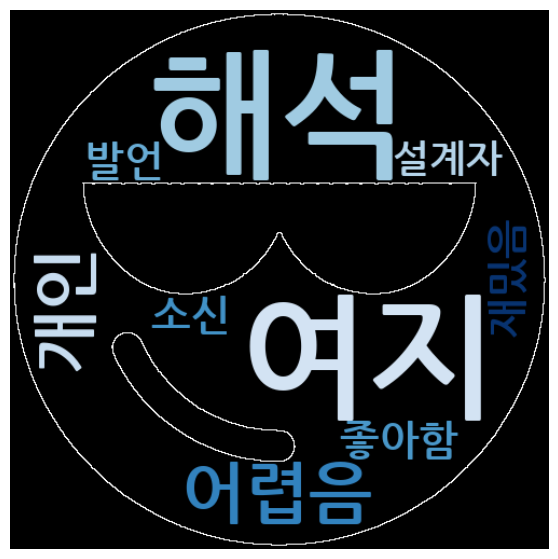

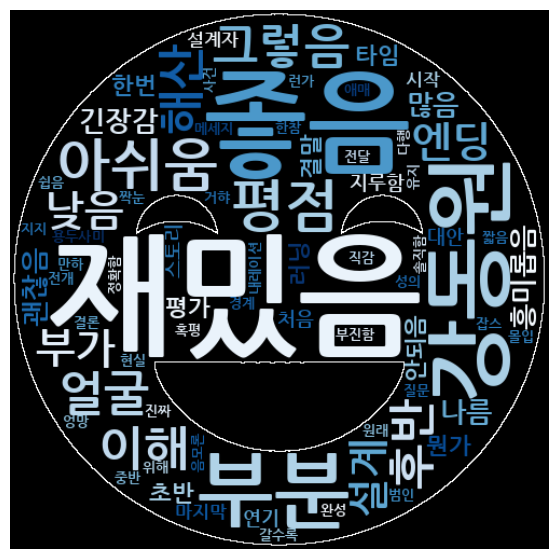

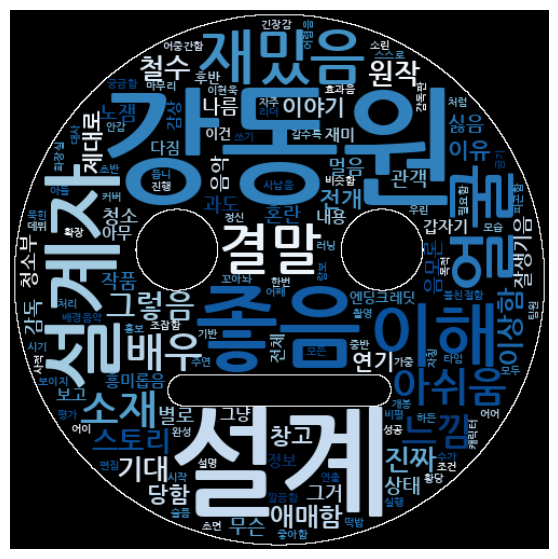

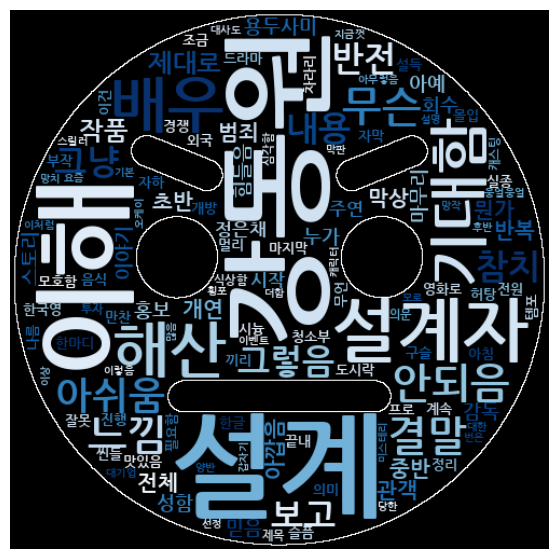

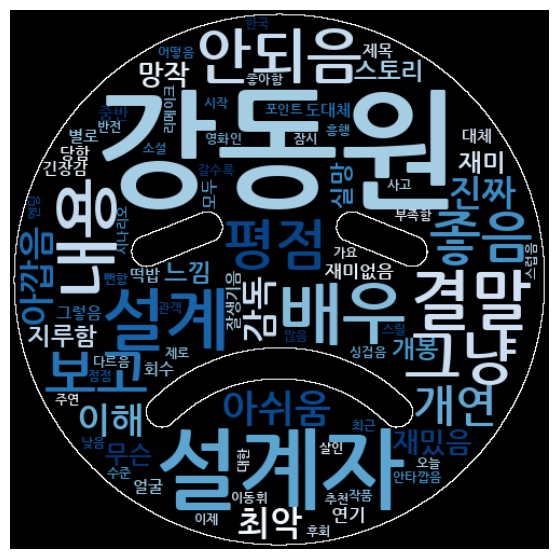

In [ ]:
# 하나의 영화에 대한 형태소 분해 후 워드클라우드로 출력
for score in single_movie_word_dict.keys():
  draw_wordcloud(int(score[-1]), single_movie_word_dict[score])

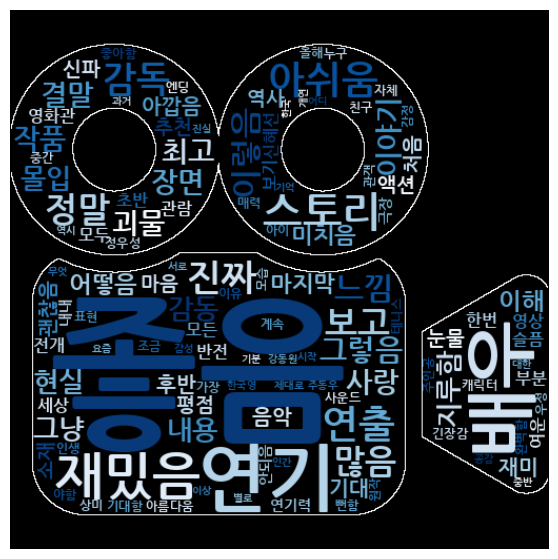

In [ ]:
#하나의 장르에서 모은 모든 리뷰를 워드 클라우드로 출력
draw_wordcloud_total(total_test)